# Text Analytics using Open AI GPT API


Analytics in the news for a given keyword (e.g., "bitcoin" or "google"), for a given date range.

## Setup

In [ ]:
!pip install -U -q openai

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import openai
import base64
import textwrap
from tqdm import tqdm

In [3]:
# Helper function that truncates the prompt if it exceeds a certain token length
# Notice that this is an approximation and OpenAI may tokenize differently.
def truncate_prompt(prompt, token_limit = 2048):
    words = prompt.split(' ')
    truncated_prompt = ""
    for word in words:
        if len(truncated_prompt.split()) < token_limit:
            truncated_prompt += word + " "
        else:
            # print(f"Truncation occurred. The prompt exceeded the token limit of {token_limit}.")
            break
    return truncated_prompt.rstrip()

In [4]:
# Helper function that calls the Open AI API and returns back the response
# We check that the prompt does not exceed the token limit and truncate if
# necessary
def get_completion(prompt, model="gpt-3.5-turbo"):

    prompt = truncate_prompt(prompt)
    try:
        messages = [{"role": "user", "content": prompt}]
        response = openai.ChatCompletion.create(
          model=model,
          messages=messages,
          temperature=0, # this is the degree of randomness of the model's output
        )
        return response.choices[0].message["content"]
    except:
        return "" # an error occured, we return back an empty answer


## Setup API keys

In [5]:
# Open AI key here
openai.api_key = '<your own API Key>'

# NewsAPI key here
newsapi_key = '<your own News API Key>'

## Get news URLs from NewsAPI



Use the NewsAPI to get URLs for news articles.

* Go to https://newsapi.org and create an account and get a key

* Modify the function `get_response` below, to work properly with the News API. The function accepts a keyword, a date range, and queries the NewsAPI using the `Everything` endpoint ([Read the documentation.](https://newsapi.org/docs/endpoints/everything)).

* The function parses the results that come back from the NewsAPI and returns back a dataframe with the results.

* The function `get_news_urls`, which is defined next, retrieves the list of URLs from the dataframe.

For example, the outcome of the command

```python
get_news_urls('inflation', '2023-06-01', '2023-06-15')
```
may return be the following list with inflation-related articles from June 1st to June 15th 2023:

```python
[ 'https://www.businessinsider.com/south-american-millennial-housing-salary-student-debt-family-2023-5',
 'https://www.cnet.com/personal-finance/mortgages/here-are-todays-refinance-rates-june-1-2023-rates-fall/',
 'https://www.economist.com/finance-and-economics/2023/06/01/why-chinas-government-might-struggle-to-revive-its-economy',
 'https://www.cnet.com/personal-finance/mortgages/mortgage-interest-rates-for-june-1-2023-rates-ease/',
 'https://www.theguardian.com/money/2023/jun/01/uk-house-prices-fall-nationwide-high-interest-rates']
 ```

 **Important**:
 * Understand how to use the parameters `q`, `from`, and `to` for the `Everything` API endpoint.(https://newsapi.org/docs/endpoints/everything)
 * Sort the results using the `sortBy` parameter and set `sortBy` to `relevance'.


 (Very) optionally, you can also use the `page` parameter and get back more than one pages of results. My assumption is that the 100 articles at a time that can be returned by setting the `pageSize` parameter are sufficient, but feel free to experiment, if you want. If you take that approach, you will need to modify the `get_response` code below.

In [6]:
def get_response(keyword, date_from, date_to):
    '''
    This code calls the NewsAPI, gets back the JSON response,
    and returns a dataframe with the matching articles
    '''
    endpoint = 'https://newsapi.org/v2/everything'

    # You need to fill-in the parameters below
    parameters = {
        'q' : keyword, # YOUR CODE HERE
        'from': date_from, # YOUR CODE HERE
        'to' : date_to, # YOUR CODE HERE
        'sortBy' : 'relevancy', # YOUR CODE HERE
        'searchIn': 'title,content,description', # YOUR CODE HERE
        'apiKey' : newsapi_key
    }

    # Issue the request against the API
    resp = requests.get (endpoint, parameters)
    # Get back the JSON response
    data = resp.json()
    
    #print(data)
    # Put the articles from the JSON response to a dataframe
    try:
        df = pd.json_normalize(data['articles'])
    except:
        # Note: if the start_date and end_date are too far in the past, 
        # OpenAI will ask me for a pay plan with an error message!
        df = data
    return df

In [7]:
# Helper function
def get_news_urls(response_df):
    '''
    This function takes as input a dataframe with the articles
    and returns back the URLs
    '''
    return list(response_df['url'].values)

In [8]:
# Note: if the start_date and end_date are too far in the past, OpenAI will ask me for a pay plan with an error message!
response_df = get_response('inflation', '2023-07-01', '2023-07-08')
response_df

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Andrew Liszewski,The $700 Liebherr Crawler Crane Is the Most Ex...,Inflation has made everything from grocery sho...,https://gizmodo.com/liebherr-crawler-crane-mos...,https://i.kinja-img.com/gawker-media/image/upl...,2023-07-03T14:20:00Z,Inflation has made everything from grocery sho...,None,Gizmodo.com
1,None,"Philippine inflation slows in June, supports e...","Philippine inflation slows in June, supports e...",https://consent.google.com/ml?continue=https:/...,None,2023-07-05T03:13:00Z,We use cookies and data to<ul><li>Deliver and ...,google-news,Google News
2,None,South Korea consumer inflation cools to 21-mon...,South Korea consumer inflation cools to 21-mon...,https://consent.google.com/ml?continue=https:/...,None,2023-07-03T23:18:00Z,We use cookies and data to<ul><li>Deliver and ...,google-news,Google News
3,None,Breakingviews - Why central banks cannot relax...,Breakingviews - Why central banks cannot relax...,https://consent.google.com/ml?continue=https:/...,None,2023-07-04T12:17:28Z,We use cookies and data to<ul><li>Deliver and ...,google-news,Google News
4,None,Euro zone consumers see lower inflation ahead ...,Euro zone consumers see lower inflation ahead ...,https://consent.google.com/ml?continue=https:/...,None,2023-07-05T08:36:00Z,We use cookies and data to<ul><li>Deliver and ...,google-news,Google News
...,...,...,...,...,...,...,...,...,...
95,Rupert Neate Wealth correspondent,World’s 722 biggest companies ‘making $1tn in ...,Collective profit comes on back of soaring ene...,https://www.theguardian.com/business/2023/jul/...,https://i.guim.co.uk/img/media/dbf557bfae0c42f...,2023-07-05T23:01:45Z,The worlds 722 biggest companies collectively ...,None,The Guardian
96,AFP,Tafeln beklagen starke Überlastung wegen hoher...,Die Tafeln in Deutschland berichten von einem ...,https://www.faz.net/aktuell/gesellschaft/tafel...,https://media1.faz.net/ppmedia/aktuell/gesells...,2023-07-04T23:43:00Z,Die Tafeln in Deutschland beklagen angesichts ...,None,Faz.net
97,F.A.Z.,Der Mythos von der Gierflation,"Die Gier der Unternehmen treibe die Inflation,...",https://www.faz.net/aktuell/wirtschaft/der-myt...,https://media1.faz.net/ppmedia/aktuell/wirtsch...,2023-07-02T09:39:02Z,"Hohe Preise, etwa für Lebensmittel oder Energi...",None,Faz.net
98,PA Media,Just Stop Oil protesters throw jigsaw pieces a...,<ul><li>Two protesters ran on to Court 18 and ...,https://www.theguardian.com/sport/2023/jul/05/...,https://i.guim.co.uk/img/media/241445af0e82ba2...,2023-07-05T13:36:39Z,Protesters have disrupted play on Court 18 at ...,None,The Guardian


In [9]:
article_urls = get_news_urls(response_df)
article_urls

['https://gizmodo.com/liebherr-crawler-crane-most-expensive-lego-technic-set-1850601155',
 'https://consent.google.com/ml?continue=https://news.google.com/rss/articles/CBMiWmh0dHBzOi8vd3d3LnJldXRlcnMuY29tL21hcmtldHMvYXNpYS9waGlsaXBwaW5lLWFubnVhbC1pbmZsYXRpb24tc2xvd3MtNTQtanVuZS0yMDIzLTA3LTA1L9IBAA?oc%3D5&gl=FR&hl=en-US&cm=2&pc=n&src=1',
 'https://consent.google.com/ml?continue=https://news.google.com/rss/articles/CBMiYmh0dHBzOi8vd3d3LnJldXRlcnMuY29tL21hcmtldHMvYXNpYS9zb3V0aC1rb3JlYS1jb25zdW1lci1pbmZsYXRpb24tY29vbHMtMjEtbW9udGgtbG93LTIwMjMtMDctMDMv0gEA?oc%3D5&gl=FR&hl=en-US&cm=2&pc=n&src=1',
 'https://consent.google.com/ml?continue=https://news.google.com/rss/articles/CBMiaGh0dHBzOi8vd3d3LnJldXRlcnMuY29tL2JyZWFraW5ndmlld3Mvd2h5LWNlbnRyYWwtYmFua3MtY2Fubm90LXJlbGF4LWluZmxhdGlvbi1maWdodC1wb2RjYXN0LTIwMjMtMDctMDQv0gEA?oc%3D5&gl=FR&hl=en-US&cm=2&pc=n&src=1',
 'https://consent.google.com/ml?continue=https://news.google.com/rss/articles/CBMiaWh0dHBzOi8vd3d3LnJldXRlcnMuY29tL21hcmtldHMvZXVyb3BlL

## Use Open AI API and GPT3.5 to summarize the news

Write a function `get_news_summary(keyword, date)` that accepts a `keyword` and a `date` as input and returns back the summary of the news headlines for that keyword and date, by analyzing the titles and descriptions of the news.

For example, the query

```python
    get_news_summary('inflation','2023-06-01')
```

may return

```
Inflation rates in various countries, including the Eurozone, Peru, and
Pakistan, have been reported. The UK housing market has seen a dip in prices,
while the US faces a potential recession. Bitcoin and other cryptocurrencies
have experienced losses, and gold is considered too expensive. The debt ceiling
deal in the US has been passed, and Amazon employees have staged a walkout.
Meanwhile, the Bank of Japan is expected to keep monetary policy ultra-loose.
```


In [10]:
# Helper function
def get_descriptions(response_df):
    '''
    This function submits the query and returns back a list of URLs from the news
    that match the keyword/date query.
    '''
    # Concatenate title and description
    title_descr = response_df['title'] + ' --- ' + response_df['description']
    # Put the title-descriptions in a list, removing NaNs
    descriptions = list(title_descr.dropna().values)
    # Create one big string with one line per title-descripion
    concatenated = "\n\n".join(descriptions)
    return concatenated


In [11]:
response_df = get_response("inflation", '2023-07-01', '2023-07-01')
response_df


,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Phillip Inman,"If there’s such a thing as an inflation quota,...","According to some theorists, the UK will have ...",https://www.theguardian.com/business/2023/jul/...,https://i.guim.co.uk/img/media/356512b734be33b...,2023-07-01T16:00:17Z,What if the UK has used up all its inflation a...,None,The Guardian
1,Molly Grace,"Today's Mortgage and Refinance Rates: July 1, ...",These are today's mortgage and refinance rates...,https://www.businessinsider.com/personal-finan...,https://i.insider.com/626bff8286fa90001905cc47...,2023-07-01T10:00:06Z,Our experts answer readers' home-buying questi...,business-insider,Business Insider
2,Phillip Inman,Rip-off Britain: why everything we buy now cos...,"As the cost of living crisis bites, consumers ...",https://www.theguardian.com/business/2023/jul/...,https://i.guim.co.uk/img/media/8e571f0c82d1712...,2023-07-01T14:34:58Z,David Cameron was famously asked the price of ...,None,The Guardian
3,David Gura,What recession? Why stocks are surging despite...,"Halfway through the year, hopes about AI and a...",https://www.npr.org/2023/07/01/1185375741/ai-r...,https://media.npr.org/assets/img/2023/06/30/ge...,2023-07-01T10:00:26Z,Markets have rallied recently as the economy h...,None,NPR
4,Calculated Risk,Real Estate Newsletter Articles this Week: New...,None,https://www.blogger.com/comment.g?blogID=10004...,None,2023-07-01T18:11:00Z,At the Calculated Risk Real Estate Newsletter ...,None,Blogger.com
...,...,...,...,...,...,...,...,...,...
95,Corey Walker,‘Just Plain Old Giveaways’: Tim Scott Praises ...,Tim Scott joined Fox News Friday to give his t...,https://dailycaller.com/2023/06/30/tim-scott-f...,https://cdn01.dailycaller.com/wp-content/uploa...,2023-07-01T01:20:45Z,Republican presidential candidate Tim Scott jo...,None,The Daily Caller
96,nellie.huang@futurenet.com (Nellie S. Huang),The Investment Strategy You Need Now,An asset allocation plan divvies up your money...,https://finance.yahoo.com/news/investment-stra...,https://s.yimg.com/ny/api/res/1.2/_pcEC_6bji1S...,2023-07-01T12:30:45Z,An asset allocation plan divvies up your money...,None,Yahoo Entertainment
97,By Hannah Wyman St. Louis Post-Dispatch,Fireworks sales going strong despite drought a...,Firework sellers are seeing similar sales to y...,https://www.stltoday.com/news/local/metro/fire...,https://bloximages.newyork1.vip.townnews.com/s...,2023-07-01T11:00:00Z,JEFFERSON COUNTY Charlie Johnson and Randy Vau...,None,STLtoday.com
98,"John Nolte, John Nolte",Nolte: Add 'Indiana Jones' to This List of Kat...,Lucasfilm chief Kathleen Kennedy has spent the...,https://www.breitbart.com/entertainment/2023/0...,https://media.breitbart.com/media/2023/07/indi...,2023-07-01T14:51:09Z,Disney’s Lucasfilm chief Kathleen Kennedy has ...,breitbart-news,Breitbart News


In [12]:
descriptions = get_descriptions(response_df)

In [13]:
print(descriptions)

If there’s such a thing as an inflation quota, has Britain already exceeded it? | Phillip Inman --- According to some theorists, the UK will have to keep prices flat for the next seven years to make up for the last three. Really?What if the UK has used up all its inflation allowance for the whole decade?This question assumes there is an optimum level of inf…

Today's Mortgage and Refinance Rates: July 1, 2023 | Rates Spike --- These are today's mortgage and refinance rates. Mortgage rates moved up this week and remain high. But they should start trending down soon as inflation slows.

Rip-off Britain: why everything we buy now costs a fortune --- As the cost of living crisis bites, consumers are asking how so many businesses have maintained or raised their profitsDavid Cameron was famously asked the price of bread a decade ago and struggled to answer, saying instead he used an electric breadmaker. The…

What recession? Why stocks are surging despite warnings of doom and gloom --- Halfw

In [14]:
def get_summary_from_open_ai(stories):
  prompt = f"""
    Summarize the following articles
    {stories}
  """
  response = get_completion(prompt)
  return response

In [15]:
openai_summary = get_summary_from_open_ai(descriptions)

# The textwrap simply allows us to print the text
# with a maximum width, so that we can read it.
print(textwrap.fill(openai_summary, width=80))

- The UK may have exceeded its inflation quota and will need to keep prices flat
for the next seven years to make up for it. - Mortgage rates have increased and
remain high, but they are expected to start trending down soon as inflation
slows. - The cost of living crisis in Britain has led to higher prices for
consumers, raising questions about how businesses have maintained or raised
their profits. - Despite warnings of a recession, stock markets are surging
halfway through the year due to hopes about AI and a strong economy. - HSBC
predicts a tough next six months for US stocks, with a recession set to dampen
the AI-fueled rally. - As Joe Biden launches his 2024 re-election campaign, the
White House is focusing on improving the perception of the president's handling
of the economy. - Rishi Sunak, the UK Chancellor, speaks about his experience
with racism and believes cricketing authorities are committed to tackling it. -
Inflation has eased in the US, but Americans are still looking 

In [16]:
def get_news_summary(keyword, date):

  # Get the news
  response_df = get_response(keyword, date_from=date, date_to=date)
  descriptions = get_descriptions(response_df)
  summary = get_summary_from_open_ai(descriptions)
  # The textwrap simply allows us to print the text
  # with a maximum width, so that we can read it.
  return textwrap.fill(summary, width=80)


In [17]:
summary = get_news_summary("inflation", "2023-06-16")
print(summary)

- Euro zone May inflation confirmed at 6.1% year-on-year, with core inflation
easing. - UK public inflation expectations eased in May, according to a Bank of
England survey. - Tesco, a British supermarket, maintained its guidance after
inflation boosted quarterly sales. - The Bank of England is expected to raise
rates to 4.75% as inflation remains high. - The Federal Reserve sees elevated
services inflation with few signs of easing. - UK food inflation remains
stubbornly high, and Tesco's CEO believes it is unfair to blame supermarkets. -
Rishi Sunak's inflation pledge was unrealistic and ignored political convention.
- Tesco's CEO believes food inflation has peaked but prices will remain high due
to Brexit. - The UK government is urged to provide emergency help as mortgage
rates continue to rise. - The cause of inflation is difficult to determine, but
who is blamed for it shapes the response. - The S&P 500 is expected to reach a
new record high before the end of 2023. - Mohamed El-Eri

## Calculate sentiment for all articles in a day and plot the score distribution



Pick a day of your choice (say `2023-06-01`) and a keyword of interest (say `inflation`).

Retrieve the URLs with the news for the keyword for that date using the `get_urls` function from Task 1.

Then create a  `get_sentiment` function that calculates, for each URL, the sentiment score. Store the results in a list of dictionaries, that looks like this:

```python
[
 {'url': 'https://www.businessinsider.com/south-american-millennial-housing-salary-student-debt-family-2023-5',
  'date': '2023-06-01',
  'sentiment': 0.1},
 {'url': 'https://www.cnet.com/personal-finance/mortgages/here-are-todays-refinance-rates-june-1-2023-rates-fall/',
  'date': '2023-06-01',
  'sentiment': 0.2},
 {'url': 'https://www.economist.com/finance-and-economics/2023/06/01/why-chinas-government-might-struggle-to-revive-its-economy',
  'date': '2023-06-01',
  'sentiment': -0.5},
 {'url': 'https://www.cnet.com/personal-finance/mortgages/mortgage-interest-rates-for-june-1-2023-rates-ease/',
  'date': '2023-06-01',
  'sentiment': 0.0},
 {'url': 'https://www.theguardian.com/money/2023/jun/01/uk-house-prices-fall-nationwide-high-interest-rates',
  'date': '2023-06-01',
  'sentiment': -0.8555},
 {'url': 'https://www.theguardian.com/business/live/2023/jun/01/uk-house-prices-fall-mortgages-factories-eurozone-inflation-markets-ftse-business-live',
  'date': '2023-06-01',
  'sentiment': 0.0}
  ]
```


 Once you have a list like the above, you can create a dataframe

 ```python
date = '2023-06-01'
keyword = 'inflation'
responde_df = get_response(keyword, date_from=date, date_to=date)
article_urls = get_news_urls(responde_df)
results = analyze_articles(article_urls, date)
df = pd.DataFrame(results)
df
```

Create a plot showing the sentiment scores for the articles, for the keyword, for the given date. You can create a histogram, or a kernel density plot (e.g., using a command like `df.sentiment.plot(kind='kde')`)

In [18]:
# Helper function: takes as input a URL and return the text from that URL
def retrieve_text_from_url(url):
    """Remove html tags from a string"""
    try:
        resp = requests.get(url)
        soup = BeautifulSoup(resp.text, "html.parser")
        return soup.get_text(strip=True)
    except:
        return ""

In [19]:
def get_sentiment(url):
    
  # For the free account, I noticed many instances of "Bad Gateway", "Server Unavailable" errors. A more managable
  # solution might be convert the article content to summary similar to what we already did above and ask
  # ChaGPT to calculate sentiment score on the summary of the article instead. Two passes.

  url_content = retrieve_text_from_url(url) # YOUR CODE HERE

  prompt = f"""
    Summarize the following text.
    {url_content}
  """
  response = textwrap.fill(get_completion(prompt),80)
  
  prompt2 = f"""
    Using SentimentIntensityAnalyzer to calculate compound sentiment score for the following text. 
    Please return ONLY the compound sentiment score without text, code or explanation. 
    No text, code or explanation, I only want the sentiment score, thank you.
    {response}
  """  
  response2 = get_completion(prompt2)
  return response2


In [20]:
def analyze_articles(urls, date):

    # Initialize a list to hold the results
    results = []

    # Iterate over all the URLs
    for url in tqdm(urls):
        # Calculate the sentiment for the URL
        sentiment = get_sentiment(url) # your code here

        # Create an entry for each URL, with the date of the URL and the score
        # For the date, notice that we pass it as a parameter above
        result = {
            "url": url, # YOUR CODE HERE
            "date": date, # YOUR CODE HERE
            "sentiment": sentiment # YOUR CODE HERE, remember to make the score a float
        }
        # Add the entry in the resylts
        results.append(result)

    return results

In [21]:
date = '2023-07-01'
keyword = 'inflation'
responde_df = get_response(keyword, date_from=date, date_to=date)
article_urls = get_news_urls(responde_df)
results = analyze_articles(article_urls, date)
df = pd.DataFrame(results)
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')  # ensuring sentiment is numeric
df

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:40<00:00,  4.00s/it]


,url,date,sentiment
0,https://www.theguardian.com/business/2023/jul/...,2023-07-01,0.0000
1,https://www.businessinsider.com/personal-finan...,2023-07-01,0.0000
2,https://www.theguardian.com/business/2023/jul/...,2023-07-01,0.0000
3,https://www.npr.org/2023/07/01/1185375741/ai-r...,2023-07-01,0.2732
4,https://www.blogger.com/comment.g?blogID=10004...,2023-07-01,0.0000
...,...,...,...
95,https://dailycaller.com/2023/06/30/tim-scott-f...,2023-07-01,0.2732
96,https://finance.yahoo.com/news/investment-stra...,2023-07-01,0.9972
97,https://www.stltoday.com/news/local/metro/fire...,2023-07-01,0.0772
98,https://www.breitbart.com/entertainment/2023/0...,2023-07-01,-0.5994


In [22]:
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce') # ensuring sentiment is numeric

Text(0.5, 1.0, 'Histogram of Sentiment with KDE')

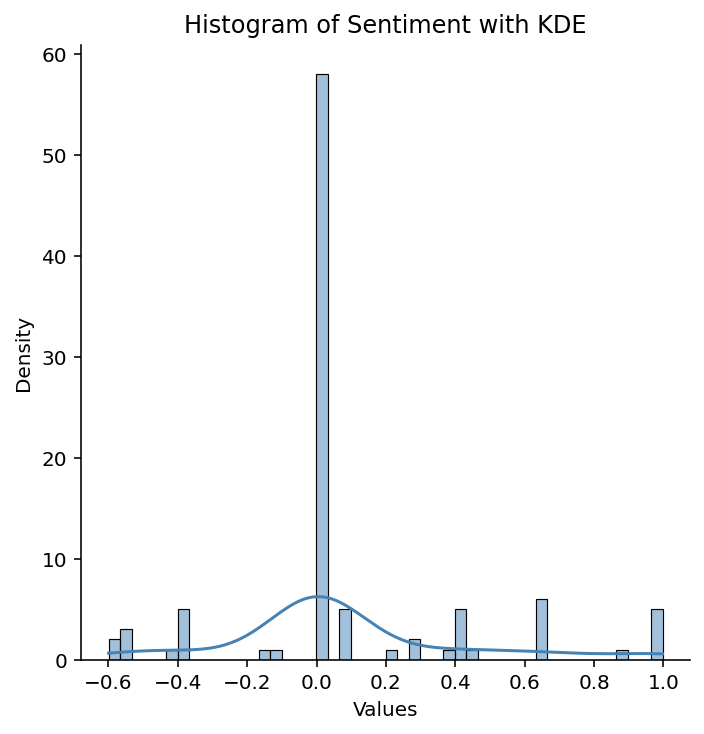

In [23]:
# Generate a plot of the sentiment scores
import seaborn as sns

# YOUR CODE HERE
sns.displot(df.sentiment,kde='True', color='steelblue')


# Set labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of Sentiment with KDE')